In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error

import os
import sys

import data_processing as dp

sys.path.append(os.path.abspath("../.."))



data = pd.read_csv('../spx_vhs.csv')

data = data.drop(columns=['high','low','close','time','vel_15'])

print(data.columns)

X, y = dp.make_prll_trgt(data=data.values, index=5,offset=30)

X = np.delete(X, 6, axis=1)

#tod_mask = (X[:, 0] >= 600) & (X[:, 0] <= 900)

#X = X[tod_mask]
#y = y[tod_mask]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

opt = tf.keras.optimizers.Adam(learning_rate=0.025)
opt1 = tf.keras.optimizers.SGD(learning_rate=0.01)

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64),
		tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.1),
        #tf.keras.layers.Dense(8, activation='relu'),       
        tf.keras.layers.Dense(1, activation='relu')  # Output layer for regression
    ])
    
    rmse='root_mean_squared_error'

    model.compile(optimizer=opt1, loss='mse', metrics=['mae','R2Score',rmse])
    return model

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_R2Score', patience=15, mode='max', restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=8, 
    min_lr=1e-7
)

2025-04-20 23:21:22.015912: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 23:21:22.029827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745205682.043688   45158 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745205682.047498   45158 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 23:21:22.061070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Index(['volume', 'ToD', 'DoW', 'v_60_.08', 'h_60_.08', 's_60_.08', 'vel_60'], dtype='object')
(415892, 6) (415892,)


I0000 00:00:1745205684.258750   45158 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6692 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [2]:
epochs = 50

model = build_model()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping,reduce_lr])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Epoch 1/50


I0000 00:00:1745205685.483954   45236 service.cc:148] XLA service 0x7f7ef4003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745205685.484084   45236 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2025-04-20 23:21:25.513082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745205685.583981   45236 cuda_dnn.cc:529] Loaded cuDNN version 90300


 45/520 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: -0.4242 - loss: 2279.3582 - mae: 40.2988 - root_mean_squared_error: 47.3779

I0000 00:00:1745205686.756786   45236 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - R2Score: -0.0664 - loss: 1718.3811 - mae: 37.0981 - root_mean_squared_error: 41.3732 - val_R2Score: -0.0446 - val_loss: 1670.9695 - val_mae: 35.3995 - val_root_mean_squared_error: 40.8775 - learning_rate: 0.0100
Epoch 2/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: 0.0312 - loss: 1560.8798 - mae: 35.7404 - root_mean_squared_error: 39.5079 - val_R2Score: 0.0238 - val_loss: 1561.5380 - val_mae: 35.5151 - val_root_mean_squared_error: 39.5163 - learning_rate: 0.0100
Epoch 3/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - R2Score: 0.0376 - loss: 1551.4050 - mae: 35.6366 - root_mean_squared_error: 39.3878 - val_R2Score: 0.0434 - val_loss: 1530.1571 - val_mae: 35.2996 - val_root_mean_squared_error: 39.1172 - learning_rate: 0.0100
Epoch 4/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - R2Score: 0.0467 - loss: 1538.0051 - mae: 35.4693 - root_mean_squared_error: 39.2174 - val_R2Score: 0.0241 - val_loss: 1561.0688 - val_mae: 35.1624 - val_root_mean_

In [3]:
print(np.mean(y<-5) + np.mean(y>5))

0.7604450193800314


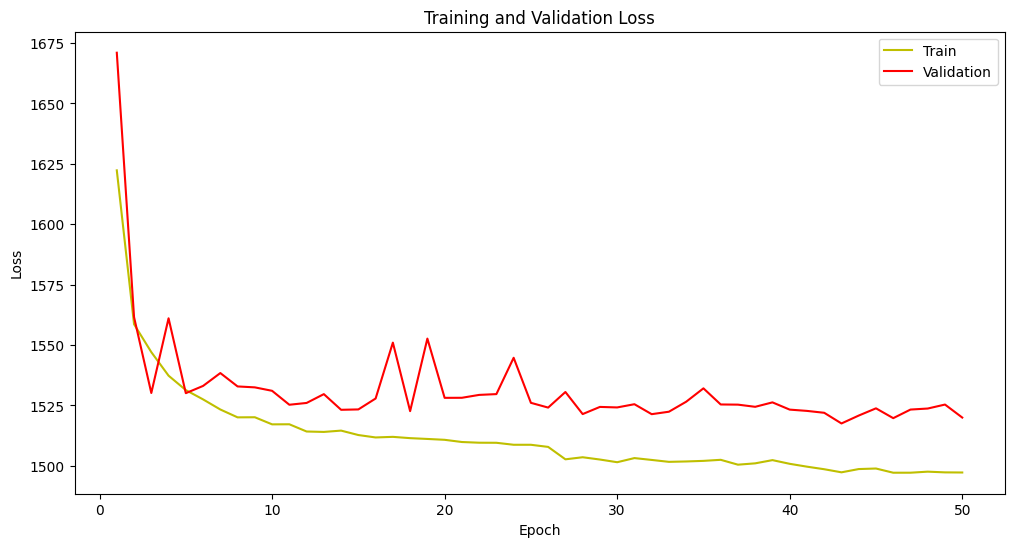

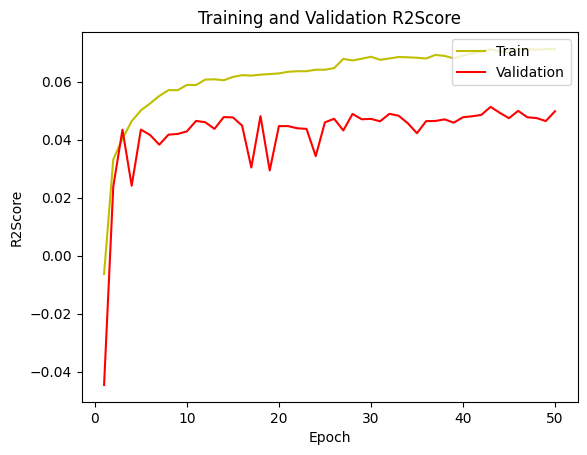

2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


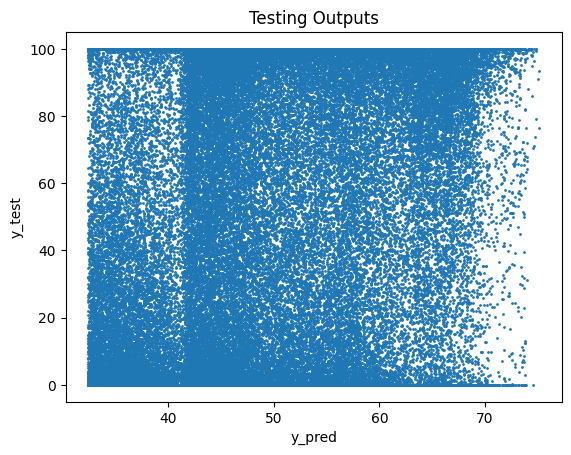

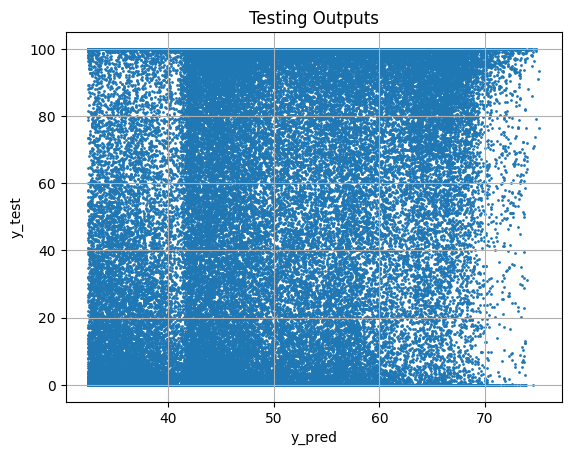

Directional Accuracy:		 100.0
Directional Accuracy >(+/-)5:	 62.53


In [4]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY

plt.plot(epochs, history.history['R2Score'], 'y', label='Training R2')
plt.plot(epochs, history.history['val_R2Score'], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


#predicting the test set results
y_pred = model.predict(X_test) 
#y_pred = y_pred > 0.5 # Predictions to class indices
'''
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Direction Classification')
plt.show()
'''

plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()
#DIRECTIONAL ACCURACY #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  
tp, fp, tn, fn = 0, 0, 0, 0
tp5, fp5, tn5, fn5 = 0, 0, 0, 0
for i in range(len(y_pred)):
    if(y_pred[i]>0):
        if(y_test[i]>0):
            tp+=1
        if(y_test[i]<0):
            fp+=1
        if(y_pred[i]>=50):
            if(y_test[i]>50):
                tp5+=1
            if(y_test[i]<50):
                fp5+=1
    if(y_pred[i]<0):
        if(y_test[i]<0):
            tn+=1
        if(y_test[i]>0):
            fn+=1
        if(y_pred[i]<=-5):
            if(y_test[i]<0):
                tn5+=1
            if(y_test[i]>0):
                fn5+=1
directionalAccuracy = ((tp+tn)/(tp+fp+tn+fn))*10000//1/100
print('Directional Accuracy:\t\t',directionalAccuracy)
directionalAccuracy5guess = ((tp5+tn5)/(tp5+fp5+tn5+fn5))*10000//1/100
print('Directional Accuracy >(+/-)5:\t',directionalAccuracy5guess)